In [1]:
# Import Packages
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import coalesce, remove_self_loops

In [2]:
print(f"Print first 10 lines of the dataset:")
printed = 0

# Load Dataset
samples = []
with gzip.open("dataset/wiki-RfA.txt.gz", "rt", encoding="utf-8", errors="ignore") as f:
    block = {}
    for line in f:
        line = line.strip()

        if printed < 10: 
            print(line)
            printed += 1

        if not line:
            if "SRC" in block and "TGT" in block and "VOT" in block:
                samples.append((block["SRC"], block["TGT"], int(block["VOT"])))
            block = {}
        else:
            key, value = line.split(":", 1)
            block[key] = value.strip()

print(f"\nTotal samples: {len(samples)}")

Print first 10 lines of the dataset:
SRC:Steel1943
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:23:13, 19 April 2013
TXT:'''Support''' as co-nom.

SRC:Cuchullain
TGT:BDD

Total samples: 198275


In [3]:
# Encode users as numerical IDs
users = list(set([s[0] for s in samples] + [s[1] for s in samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])

Unique users: 11381
[('', np.int64(0)), ('Noisalt', np.int64(7094)), ('DisturbedNerd999', np.int64(2725)), ('Llampadari', np.int64(5833)), ('Stefan', np.int64(9260)), ('Christiaan', np.int64(1934)), ('Sd31415', np.int64(8675)), ('Jon Harald Søby', np.int64(5091)), ('Schutz', np.int64(8635)), ('Vizjim', np.int64(10402))]


In [4]:
def create_pyg_data(num_nodes, edge_index):
    x = torch.arange(num_nodes, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

In [5]:
# Dataset build (edge list + label)
X = []
y = []
for src, tgt, vot in samples:
    if src in user_map and tgt in user_map:
        X.append([user_map[src], user_map[tgt]])
        y.append(vot)

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

In [6]:
# Split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split training and validation set
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # oppure 'mps' su Mac
num_users = len(user_map)

# === Message-passing edge_index SOLO dal training set + cleanup ===
train_edge_index = X_tr.t().contiguous()  # [2, E_train]
train_edge_index, _ = remove_self_loops(train_edge_index)
train_edge_index, _ = coalesce(train_edge_index, None, num_nodes=num_users)

data = create_pyg_data(num_users, train_edge_index)
print(f"Grafo (training) creato con {data.num_nodes} nodi e {data.num_edges} archi.")

Grafo (training) creato con 11381 nodi e 137699 archi.


In [8]:
# === (E) class weights calcolati da y_train ===
# cross_entropy vuole classi 0..C-1: {-1,0,1} -> {0,1,2}
y_tr_ce  = y_tr + 1
y_val_ce = y_val + 1
y_test_ce = y_test + 1

counts = torch.bincount(y_tr_ce, minlength=3).float()  # [3]
base_w = (counts.sum() / (len(counts) * counts))   # N/(C*n_c)
alpha = 0.5  # prova 0.5, poi 0.3/0.7
class_weights = base_w.pow(alpha).to(device)
print("Train class counts [Oppose, Neutral, Support]:", counts.tolist())
print("Class weights:", class_weights.tolist())

Train class counts [Oppose, Neutral, Support]: [29647.0, 9106.0, 104005.0]
Class weights: [1.2669200897216797, 2.2859976291656494, 0.6764138340950012]


In [9]:
# === LinkNeighborLoader: batching vero sui link ===
train_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[30, 15],                 # 1-hop, 2-hop
    edge_label_index=X_tr.t().contiguous(),
    edge_label=y_tr_ce,
    batch_size=2048,
    shuffle=True
)

val_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[30, 15],
    edge_label_index=X_val.t().contiguous(),
    edge_label=y_val_ce,
    batch_size=4096,
    shuffle=False
)

test_loader = LinkNeighborLoader(
    data=data,                              # IMPORTANT: message passing sempre sul grafo train
    num_neighbors=[30, 15],
    edge_label_index=X_test.t().contiguous(),
    edge_label=y_test_ce,
    batch_size=4096,
    shuffle=False
)

In [10]:
class GNNVotePredictor(nn.Module):
    def __init__(self, num_nodes, emb_dim=64, hidden_dim=128, out_dim=3):
        """
        Args:
            num_nodes: Numero totale di utenti unici.
            emb_dim: Dimensione dell'embedding iniziale (learnable).
            hidden_dim: Dimensione delle feature nascoste della GNN.
            out_dim: Numero di classi di voto (-1, 0, 1) -> 3 classi.
        """
        super().__init__()
        
        # Sostituisce le features one-hot con vettori densi
        self.node_emb = nn.Embedding(num_nodes, emb_dim)
        
        # Graph layers
        self.conv1 = SAGEConv(emb_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        
        # Link Predictor
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, out_dim)
        )

    def forward(self, batch: Data):
        """
        Args:
            x: Input node features/IDs (tutti i nodi).
            edge_index: La struttura completa del grafo per il message passing.
            src_batch: Indici degli utenti votanti nel batch corrente.
            tgt_batch: Indici degli utenti candidati nel batch corrente.
        """
        # embedding iniziali solo per i nodi campionati
        x = self.node_emb(batch.n_id)
        
        # message passing sul subgrafo
        x = self.conv1(x, batch.edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.conv2(x, batch.edge_index)
        x = F.relu(x)

        # decode sui link del batch
        src, tgt = batch.edge_label_index  # indici locali
        h_src = x[src]
        h_tgt = x[tgt]

        # Concatena e classifica
        #edge_feat = torch.cat([h_src, h_tgt], dim=1)
        edge_feat = torch.cat([h_src, h_tgt, torch.abs(h_src - h_tgt), h_src * h_tgt], dim=1)
        return self.mlp(edge_feat)

In [11]:
model = GNNVotePredictor(num_nodes=num_users).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
class_weights = class_weights.to(device)

In [12]:
def eval_loader(loader):
    model.eval()
    y_pred_all, y_true_all = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            pred = logits.argmax(dim=1).cpu()
            y_pred_all.append(pred)
            y_true_all.append(batch.edge_label.cpu())
    y_pred = torch.cat(y_pred_all).numpy()
    y_true = torch.cat(y_true_all).numpy()
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    return macro_f1, y_true, y_pred

In [13]:
# Training Loop
best_f1 = -1.0
best_state = None
patience = 5
bad_epochs = 0

for epoch in range(1, 51):
    model.train()
    total_loss, total_ex = 0.0 ,0
    
    for batch in train_loader:
        batch = batch.to(device)
    
        optimizer.zero_grad()
        out = model(batch)
        loss = F.cross_entropy(out, batch.edge_label, weight=class_weights)
        
        loss.backward()
        optimizer.step()

        bs = batch.edge_label.size(0)
        total_loss += loss.item() * bs
        total_ex += bs
    
    train_loss = total_loss / total_ex
    val_f1, _, _ = eval_loader(val_loader)
    print(f"Epoch {epoch:02d} | Loss(avg): {train_loss:.4f} | Val macro-F1: {val_f1:.4f}")

    if val_f1 > best_f1 + 1e-4:
        best_f1 = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping. Best Val macro-F1: {best_f1:.4f}")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)

Epoch 01 | Loss(avg): 0.9924 | Val macro-F1: 0.2810
Epoch 02 | Loss(avg): 0.9553 | Val macro-F1: 0.4055
Epoch 03 | Loss(avg): 0.8989 | Val macro-F1: 0.4468
Epoch 04 | Loss(avg): 0.8515 | Val macro-F1: 0.4628
Epoch 05 | Loss(avg): 0.8205 | Val macro-F1: 0.5042
Epoch 06 | Loss(avg): 0.7994 | Val macro-F1: 0.5321
Epoch 07 | Loss(avg): 0.7836 | Val macro-F1: 0.5379
Epoch 08 | Loss(avg): 0.7684 | Val macro-F1: 0.5261
Epoch 09 | Loss(avg): 0.7615 | Val macro-F1: 0.5343
Epoch 10 | Loss(avg): 0.7466 | Val macro-F1: 0.5513
Epoch 11 | Loss(avg): 0.7389 | Val macro-F1: 0.5576
Epoch 12 | Loss(avg): 0.7321 | Val macro-F1: 0.5631
Epoch 13 | Loss(avg): 0.7241 | Val macro-F1: 0.5571
Epoch 14 | Loss(avg): 0.7163 | Val macro-F1: 0.5476
Epoch 15 | Loss(avg): 0.7103 | Val macro-F1: 0.5770
Epoch 16 | Loss(avg): 0.7033 | Val macro-F1: 0.5741
Epoch 17 | Loss(avg): 0.6968 | Val macro-F1: 0.5688
Epoch 18 | Loss(avg): 0.6916 | Val macro-F1: 0.5612
Epoch 19 | Loss(avg): 0.6842 | Val macro-F1: 0.5735
Epoch 20 | L

GNN Classification Report:
              precision    recall  f1-score   support

      Oppose       0.54      0.67      0.60      8235
     Neutral       0.24      0.30      0.26      2530
     Support       0.90      0.82      0.86     28890

    accuracy                           0.76     39655
   macro avg       0.56      0.60      0.57     39655
weighted avg       0.79      0.76      0.77     39655



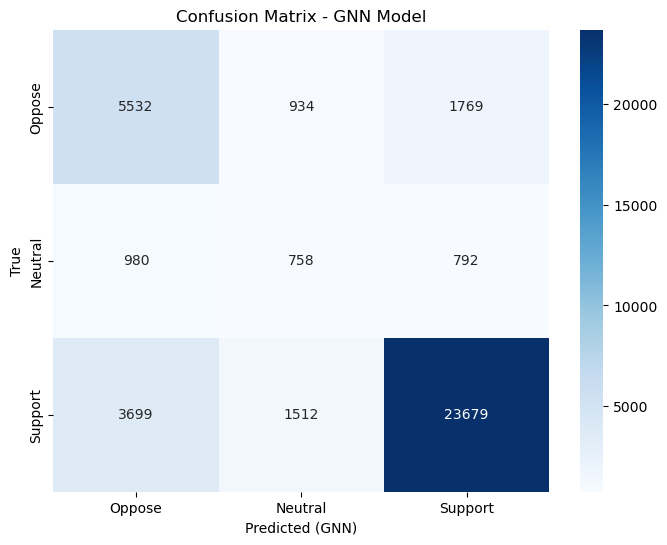

In [14]:
model.eval()
y_pred_all = []
y_true_all = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        logits = model(batch)
        pred = logits.argmax(dim=1).cpu()
        y_pred_all.append(pred)
        y_true_all.append(batch.edge_label.cpu())

y_pred = torch.cat(y_pred_all).numpy()
y_true = torch.cat(y_true_all).numpy()

# Report di Classificazione
print("GNN Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Oppose", "Neutral", "Support"]))

# Matrice di Confusione
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose", "Neutral", "Support"],
            yticklabels=["Oppose", "Neutral", "Support"])
plt.xlabel("Predicted (GNN)")
plt.ylabel("True")
plt.title("Confusion Matrix - GNN Model")
plt.show()